**Notes from kick-off meeting**
- dry season (Jan-Apr) is irrelevant for precip - wet season (May-Dec) largely irrelevant for PET
- PET is expected to be insignificant compared to water usage - typically about 1-3mm/day in wet season, 5-8mm/day in dry season
- temperatures have increased by about 1C in this region (2C for nighttime temperatures) - no change in windspeed or direction
- use ACP core stations (50 or so) within the watershed - could also include coastal stations from STRI but these tend to be shorter duration
- El Nino has strong correlation with dry years - La Nina is less strongly linked to wet years (although variability is higher in wet years)  
&nbsp;
- over long time series there's clear evidence of a decadal oscillation - which may be linked to the AMO
- December precip was very low this year: maybe that would also be worth looking at? (Also May, which has more of an effect on lake levels dropping - December more important for replenishment)
&nbsp;
- an interesting follow-up question: what happens in the second half of the second year? This is when replenishment should occur

In [2]:
import sys; sys.path.append('..'); from wwa import *
from scipy.stats import spearmanr, pearsonr
import calendar

warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", message = ".+naturalearth.+")

mapproj = cartopy.crs.PlateCarree()
# xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7] # original bounds
xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7] # revised after comparison with station data

bci_px = {"lon" : -79.838234, "lat" : 9.163114}

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
gridlines = [i+1 for i in range(366) if (days[i].day) == 1]
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))

# Reshape maps of fitted trends


In [3]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [4]:
for ds in ["chirps", "mswep", "era5land", "era5land-1979-2021"]:
    
    # load map to be used to reshape
    tmplt = xr.open_dataset("data/"+ds+"_pr-rs_tmplt.nc").pr
    
    df = pd.read_csv("res/res_rs_"+ds+"-gridded.csv", index_col = 0)
    mdl_res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
    mdl_res.to_netcdf("res/res_rs_"+ds+"-gridded.nc")

# Maps of fitted trends

In [10]:
datasets = ["chirps", "mswep", "era5land-1979-2021"]

# load results of model fitted to gridded data
da_res = { ds : xr.open_dataset("res/res_rs_"+ds+"-gridded.nc") for ds in datasets }

# load results of model fitting per station
stn_res = merge_byindex([pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]], 
                          pd.read_csv("res/res_rs_stations-filled_1979-2023.csv", index_col = 0).transpose()]).dropna(axis = 0, how = "any")

sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))

In [11]:
plot_kwargs = {"mu0"        : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "disp"       : {"cmap" : "viridis", "vmin" : 0},
               "alpha_gmst" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500},
               "alpha_nino" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500},
               "event_magnitude" : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "return_period"   : {"cmap" : "viridis", "vmin" : 0, "vmax" : 100},
               "rp_neut"         : {"cmap" : "viridis", "vmin" : 0, "vmax" : 250},
               "PR_hist"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "PR_neut"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "dI_rel_hist" : {"cmap" : "BrBG", "vmin" : -15, "vmax" : 15},
               "dI_rel_neut" : {"cmap" : "BrBG", "vmin" : -15, "vmax" : 15}}

main = {"dI_rel_hist" : "% change in rainy season precip due to 1.2C change in GMST",
        "dI_rel_neut" : "% change in rainy season precip due to current El Nino state"}

label = {"dI_rel_hist" : "% change in rainy season precipitation",
        "dI_rel_neut" : "% change in rainy season precipitation"}

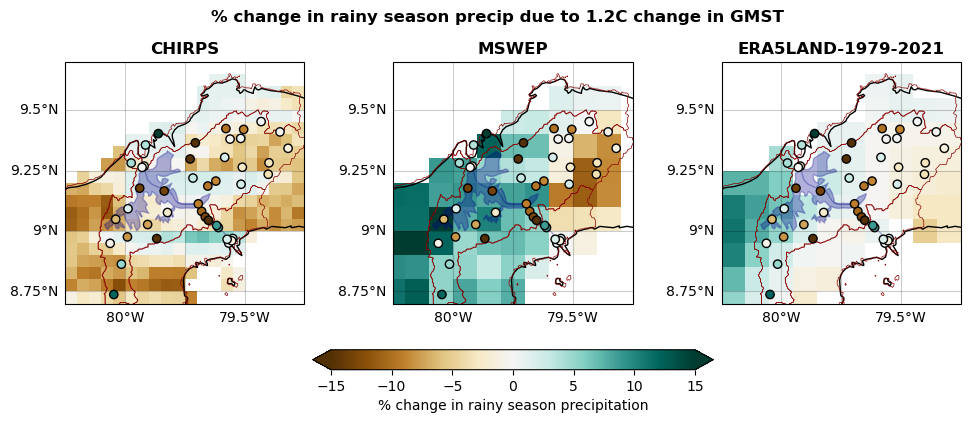

In [12]:
varnm = "dI_rel_hist"

fig, axs = plt.subplots(ncols = 3, figsize = (12.5,4), dpi = 100, subplot_kw={"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.05)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.065, "shrink" : 0.9, "pad" : 0.15, "extend" : "both"} | {"label" : label[varnm]}

for i in range(len(datasets)):
    ds = datasets[i]
    da = da_res[ds]
    ax = axs[i]
    
    cbar = da[varnm].plot(ax = ax, add_colorbar = False, **plot_kwargs[varnm])
    
    ax.scatter(stn_res.lon, stn_res.lat, c = stn_res[varnm], **plot_kwargs[varnm], zorder = 99, edgecolor = "k")

    ax.set_title(ds.upper(), fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.25), ylocs = np.arange(np.floor(yn),yx+0.5,0.25))
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5))
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)
    
plt.colorbar(cbar, ax = axs, **cbar_kwargs)
plt.suptitle(main[varnm], fontweight = "bold", y = 1.01)
    
plt.savefig("fig/fitted-models-gridded_"+varnm+".png")

# Annual precip vs lake levels

In [46]:
nino_strong = [y in [1982,1997,2014,2015,2023] for y in chirps.time.dt.year]
nino_mod = [y in [2002,2004,2006,2009,2018] for y in chirps.time.dt.year]


In [69]:
lake = pd.read_csv("data/Download_Gatun_Lake_Water_Level_History.csv", parse_dates = ["DATE_LOG"], index_col = 0)
lake = lake.rename(columns = {"GATUN_LAKE_LEVEL(FEET)" : "level"}).loc[slice("1981", "2023")]
lake.loc[lake.level == 0, "level"] = np.nan # remove zeros
lake = lake.resample("AS-JAN").mean()

In [42]:
chirps = xr.open_dataset("data/chirps05_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx)).mean(["lon", "lat"]).resample(time = "AS-JAN").sum().sel(time = slice(None, "2023"))

<BarContainer object of 43 artists>

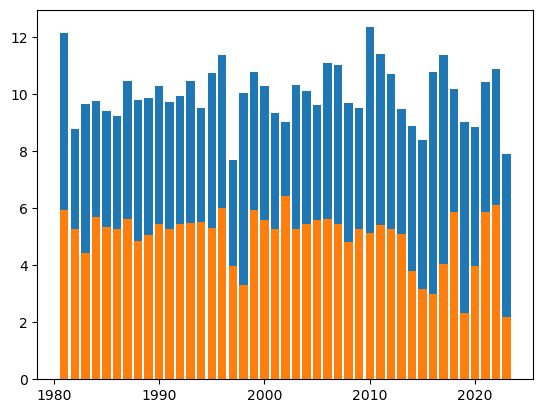

In [43]:
plt.bar(chirps.time.dt.year, (chirps - chirps.mean()) / chirps.std() + 10)
plt.bar(lake.index.year, (lake.level - lake.level.mean()) / lake.level.std() + 5)

(1000.0, 3597.7219482421874)

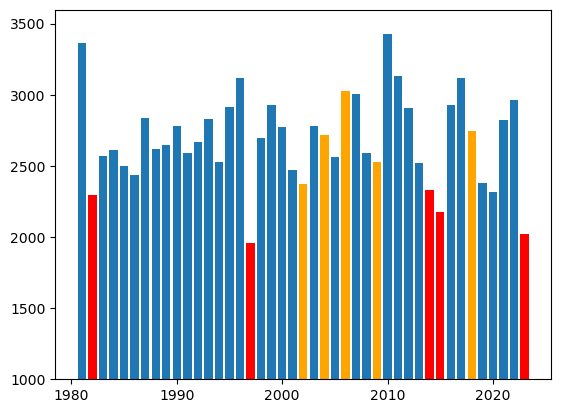

In [71]:
plt.bar(chirps.time.dt.year, chirps)
plt.bar(chirps.sel(time = nino_mod).time.dt.year, chirps.sel(time = nino_mod), color = "orange")
plt.bar(chirps.sel(time = nino_strong).time.dt.year, chirps.sel(time = nino_strong), color = "red")
plt.ylim(1000)

In [59]:
nino = pd.read_csv("ts/panama_nino-rs.dat", sep = " ", comment = "#", header = None, index_col = 0, names = ["nino_rs"]).loc[slice("1981","2023")]

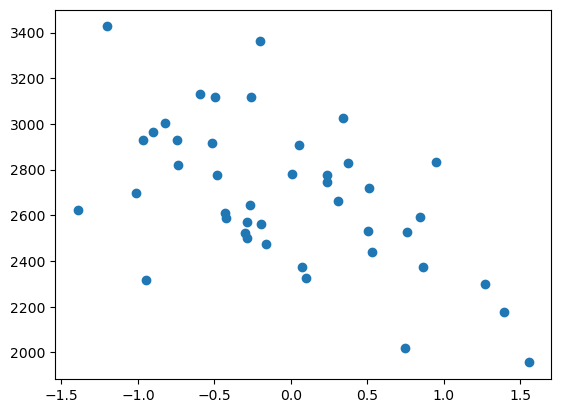

In [60]:
plt.scatter(nino, chirps)

(78.0, 91.57050000000001)

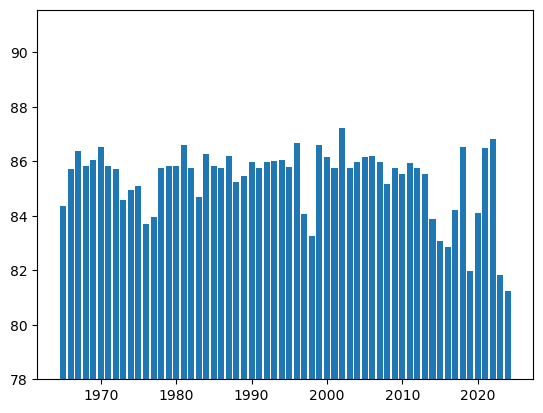

In [68]:
plt.bar(lake.index.year, lake.level)
plt.ylim(78,None)